In [3]:
import requests
from zipfile import ZipFile
import os
import py7zr
import pandas as pd
import geopandas as gpd


# --- importation ddu dataset sur le niveau de vie et le niveau de pollution par carreaux en
# Ile de France (données Airparif et Insee) ---

def telecharger_donnees():
    print("téléchargement des données (environ 2 minutes)")

    dossier_data = os.path.join(os.getcwd(), "data_carreaux")    # --- téléchargement des données carroyées de niveau de vie Insee ---
    URL_INSEE_ZIP = "https://www.insee.fr/fr/statistiques/fichier/7655475/Filosofi2019_carreaux_200m_shp.zip"
    intermediaire_zip = "donnees.zip"
    reponse = requests.get(URL_INSEE_ZIP)
    if reponse.status_code == 200:
        print("téléchargement réussi -> décompression")
        with open(intermediaire_zip, "wb") as f:
            f.write(reponse.content)
        with ZipFile(intermediaire_zip, 'r') as zip_ref:
            zip_ref.extractall(dossier_data)
        chemin_fichier_7z = os.path.join(dossier_data, "Filosofi2019_carreaux_200m_shp.7z")
        print("decompression zip terminée -> deuxième décompression")
        with py7zr.SevenZipFile(chemin_fichier_7z, mode="r") as z:
            z.extractall(path=dossier_data)

        # suppression des deux fichiers zip:
        os.remove(os.path.join(os.getcwd(), intermediaire_zip))
        os.remove(chemin_fichier_7z)
    else:
        print(f"echec du télechargement code status : {reponse.status_code}")

    # --- suppression des fichiers inutiles de la réunion et de la martinique---
    extensions = ["dbf", "prj", "shp", "shx"]
    for e in extensions:
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_mart.{e}"))
        except Exception:
            print("erreur_suppresion_martinique")
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_reun.{e}"))
        except Exception:
            print("erreur_suppresion_reunion")

    # --- conversion en dataframe centré sur l'idf ---
    df = gpd.read_file(os.path.join(dossier_data, "carreaux_200m_met.shp"))

    # --- récupération des départements associés à lcog_geo ---
    url_base = "https://geo.api.gouv.fr/communes"
    parametres = {
        "codeRegion": "11",              # Île-de-France
        "type": "commune-actuelle,arrondissement-municipal",
        "fields": "nom,code,codeDepartement",  # Les colonnes voulues
        "format": "json"}
    response = requests.get(url_base, params=parametres)
    df2 = pd.DataFrame(response.json())

    # --- rightjoin ---
    df3 = pd.merge(df, df2, left_on="lcog_geo", right_on="code", how="right")
    df3.head()

    # --- récupération des données de pollution ---
    polluants = ["no2", "pm10", "pm25"]
    for p in polluants:
        df3[p] = pd.read_csv(os.path.join(dossier_data, f"donnees_pollution{p}_checkpoint.csv"))

    # --- suppression des données téléchargées ---
    for e in extensions:
        try:
            os.remove(os.path.join(dossier_data, f"carreaux_200m_met.{e}"))
        except Exception:
            print("erreur_suppresion_métropole")
    return (df3)

In [4]:
df=telecharger_donnees()
df.head()

téléchargement des données (environ 2 minutes)
téléchargement réussi -> décompression
decompression zip terminée -> deuxième décompression


,idcar_200m,idcar_1km,idcar_nat,i_est_200,i_est_1km,lcog_geo,ind,men,men_pauv,men_1ind,...,ind_65_79,ind_80p,ind_inc,geometry,nom,code,codeDepartement,no2,pm10,pm25
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,Paris,75056,75,NaN,NaN,NaN
1,CRS3035RES200mN2830600E3770400,CRS3035RES1000mN2830000E3770000,CRS3035RES4000mN2828000E3768000,1.0,1.0,77001,8.5,3.4,0.3,1.2,...,0.0,0.9,0.0,"POLYGON ((667533.681 6804377.086, 667515.15 68...",Achères-la-Forêt,77001,77,7.457788,14.43,7.88
2,CRS3035RES200mN2830800E3770400,CRS3035RES1000mN2830000E3770000,CRS3035RES4000mN2828000E3768000,0.0,1.0,77001,38.0,16.0,0.0,1.0,...,4.0,1.0,0.0,"POLYGON ((667515.15 6804576.027, 667496.618 68...",Achères-la-Forêt,77001,77,7.480239,14.42,7.87
3,CRS3035RES200mN2830800E3770600,CRS3035RES1000mN2830000E3770000,CRS3035RES4000mN2828000E3768000,1.0,1.0,77001,16.0,6.4,0.6,2.3,...,0.0,1.7,0.0,"POLYGON ((667714.265 6804595.052, 667695.734 6...",Achères-la-Forêt,77001,77,7.492401,14.42,7.87
4,CRS3035RES200mN2831000E3770600,CRS3035RES1000mN2831000E3770000,CRS3035RES4000mN2828000E3768000,0.0,0.0,77001,39.0,17.0,1.0,4.0,...,5.0,2.0,0.0,"POLYGON ((667695.734 6804793.994, 667677.203 6...",Achères-la-Forêt,77001,77,7.504329,14.41,7.86


In [6]:
df = df.to_crs(epsg=2154)

# Sauvegarde en format GeoJSON (très pratique car il contient géométrie + données)
df.to_file("idf_pollution_revenus.geojson", driver='GeoJSON')

Maintenant import des axes routiers

In [5]:
import osmnx as ox

def recuperer_routes_idf():
    print("Récupération des routes en cours")
    
    # on récupère tous les types de routes jusqu'aux départementales
    # primary Grandes Départementales ou axes urbains majeurs
    # secondary	Routes Départementales classiques (relient les villes moyennes)
    mes_axes = ["motorway", "trunk", "primary", "secondary"]
    
    # On télécharge les axes routiers spécifiquement pour l'Île-de-France
    routes_idf = ox.features_from_place("Île-de-France, France", tags={"highway": mes_axes})
    
    # On ne garde que les géométries de type Ligne (LineString) pour éviter les erreurs
    routes_idf = routes_idf[routes_idf.geometry.type.isin(['LineString', 'MultiLineString'])]
    
    print(f"Terminé ! {len(routes_idf)} segments de routes récupérés.")
    return routes_idf

# Utilisation
base_routes = recuperer_routes_idf()

C:\Users\quent\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\osmnx\bearing.py:16: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  import scipy


Récupération des routes en cours
Terminé ! 61596 segments de routes récupérés.


In [7]:
df=df.to_crs(epsg=2154)
base_routes=base_routes.to_crs(epsg=2154)

In [8]:
# On crée une zone de 100m de chaque côté des routes
distance_influence = 100 
routes_buffer = base_routes.copy()
routes_buffer['geometry'] = base_routes.buffer(distance_influence)

In [10]:
# 1. On fait la jointure spatiale 
carreaux_qui_touchent = gpd.sjoin(df, routes_buffer, how="inner", predicate="intersects")

# 2. On récupère la liste des index des carreaux qui ont touché une route
indices_exposes = carreaux_qui_touchent.index.unique()

# 3. On crée la colonne dans le df d'origine
# Par défaut, tout le monde est à False
df['proche_axe_majeur'] = False

# On passe à True uniquement ceux qui sont dans la liste des indices exposés
df.loc[indices_exposes, 'proche_axe_majeur'] = True

In [11]:
print(df.columns)

Index(['idcar_200m', 'idcar_1km', 'idcar_nat', 'i_est_200', 'i_est_1km',
       'lcog_geo', 'ind', 'men', 'men_pauv', 'men_1ind', 'men_5ind',
       'men_prop', 'men_fmp', 'ind_snv', 'men_surf', 'men_coll', 'men_mais',
       'log_av45', 'log_45_70', 'log_70_90', 'log_ap90', 'log_inc', 'log_soc',
       'ind_0_3', 'ind_4_5', 'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39',
       'ind_40_54', 'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc', 'geometry',
       'nom', 'code', 'codeDepartement', 'no2', 'pm10', 'pm25',
       'proche_axe_majeur'],
      dtype='object')


In [12]:

# 1. Calculer le niveau de vie moyen par personne dans chaque carreau
# (Somme des niveaux de vie / nombre d'individus)
df['niveau_de_vie_unitaire'] = df['ind_snv'] / df['ind']

# 2. Calculer la médiane de ce niveau de vie pour chaque ville
df['ville_niveau_vie_median'] = df.groupby('nom')['niveau_de_vie_unitaire'].transform('median')

# 3. Calculer l'écart relatif (en %) pour voir la ségrégation
# (Revenu du carreau - Revenu médian de la ville) / Revenu médian de la ville
df['ecart_segregation_pct'] = (df['niveau_de_vie_unitaire'] - df['ville_niveau_vie_median']) / df['ville_niveau_vie_median'] * 100

In [31]:
#le df est trop long, big flemme
df2 = df[[
    'proche_axe_majeur', 
    'nom', 
    'codeDepartement',
    'code', 
    'ind', 
    'no2',
    'niveau_de_vie_unitaire', 
    'pm10', 
    'pm25', 
    'ecart_segregation_pct', 
    'geometry'
]]
df2.head(85)


,proche_axe_majeur,nom,codeDepartement,code,ind,no2,niveau_de_vie_unitaire,pm10,pm25,ecart_segregation_pct,geometry
0,False,Paris,75,75056,NaN,NaN,NaN,NaN,NaN,NaN,None
1,False,Achères-la-Forêt,77,77001,8.5,7.457788,33660.447059,14.43,7.88,15.239274,"POLYGON ((667533.681 6804377.086, 667515.15 68..."
2,False,Achères-la-Forêt,77,77001,38.0,7.480239,27952.523684,14.42,7.87,-4.302265,"POLYGON ((667515.15 6804576.027, 667496.618 68..."
3,False,Achères-la-Forêt,77,77001,16.0,7.492401,33660.443750,14.42,7.87,15.239263,"POLYGON ((667714.265 6804595.052, 667695.734 6..."
4,False,Achères-la-Forêt,77,77001,39.0,7.504329,29675.264103,14.41,7.86,1.595677,"POLYGON ((667695.734 6804793.994, 667677.203 6..."
...,...,...,...,...,...,...,...,...,...,...,...
80,False,Amillis,77,77002,24.5,5.805741,28673.538776,15.03,8.36,5.467005,"POLYGON ((709900.223 6847761.584, 709881.677 6..."
81,False,Amillis,77,77002,2.0,5.796589,28673.550000,15.03,8.36,5.467046,"POLYGON ((710099.381 6847780.534, 710080.834 6..."
82,False,Amillis,77,77002,8.0,5.763309,27187.212500,15.03,8.36,0.000000,"POLYGON ((710896.01 6847856.328, 710877.465 68..."
83,False,Amillis,77,77002,10.0,5.751575,27187.220000,15.03,8.36,0.000028,"POLYGON ((711095.167 6847875.276, 711076.622 6..."


In [17]:
nombre_proches = df2['proche_axe_majeur'].sum()
print(f"Il y a {nombre_proches} carreaux à proximité d'un axe majeur.")

Il y a 25027 carreaux à proximité d'un axe majeur.


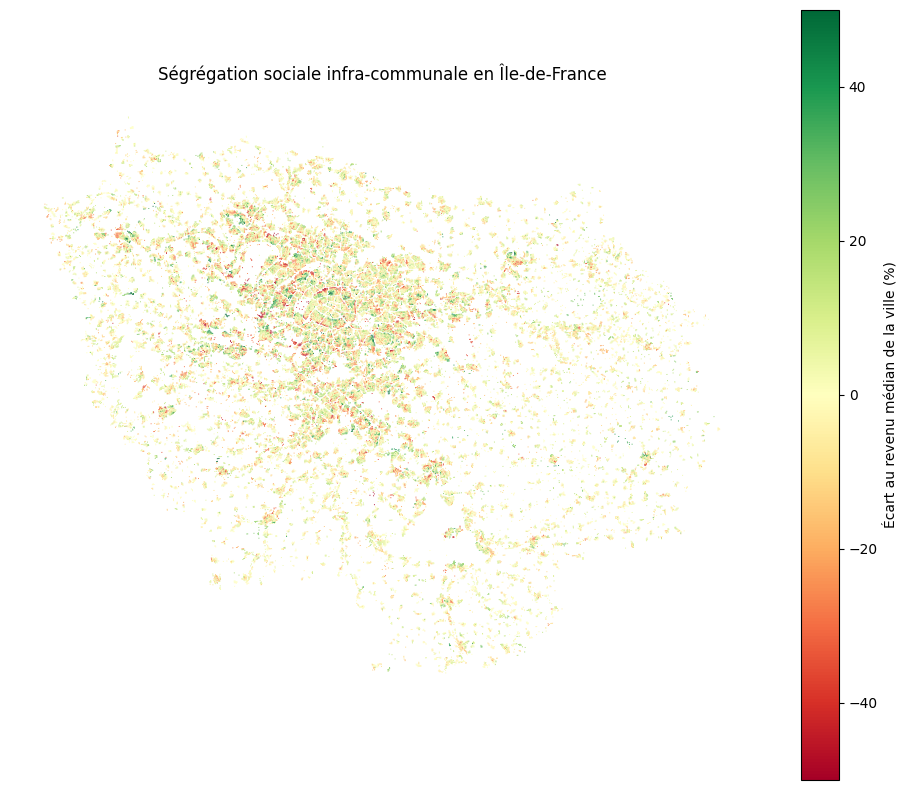

In [19]:
import matplotlib.pyplot as plt

# Création de la figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Affichage des carreaux
# On définit vmin et vmax de façon symétrique (ex: -50% à +50%)
# Tout ce qui dépasse 50% sera vert foncé, tout ce qui est sous -50% sera rouge foncé
df2.plot(column='ecart_segregation_pct', 
         cmap='RdYlGn', 
         legend=True, 
         ax=ax,
         vmin=-50,  # Force le rouge à partir de -50%
         vmax=50,   # Force le vert à partir de +50%
         legend_kwds={'label': "Écart au revenu médian de la ville (%)"},
         edgecolor='none')    # Enlever les bordures pour fluidifier la carte

ax.set_title("Ségrégation sociale infra-communale en Île-de-France")
ax.axis('off') # Cache les coordonnées GPS pour plus d'esthétisme
plt.show()

In [34]:
# 1. On crée une copie dédiée à la régression pour ne pas perdre de données globales
# On filtre pour ne garder que les lignes où l'écart ET la pollution sont valides
import numpy as np
colonnes_reg = ['ecart_segregation_pct', 'no2', 'pm10', 'pm25']

# On supprime les NaN et les valeurs infinies (inf)
df_clean = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=colonnes_reg)

print(f"Lignes supprimées car incomplètes : {len(df2) - len(df_clean)}")

Lignes supprimées car incomplètes : 199


In [33]:
import statsmodels.api as sm

def analyser_correlation(polluant,df):
    # On prépare les données (X = écart de revenu, y = pollution)
    X = df['ecart_segregation_pct']
    y = df[polluant]
    
    # On ajoute une constante (pour l'ordonnée à l'origine)
    X = sm.add_constant(X)
    
    # On crée et on entraîne le modèle
    modele = sm.OLS(y, X).fit()
    print(f"--- Analyse pour le {polluant.upper()} ---")
    print(f"Coefficient (pente) : {modele.params[1]:.4f}")
    print(f"R-squared : {modele.rsquared:.4f}")
    print(f"P-value : {modele.pvalues[1]:.4e}") # Si < 0.05, c'est significatif
    print("-" * 30)
    return modele

# Exécution pour les 3 polluants
for p in ['no2', 'pm10', 'pm25']:
    analyser_correlation(p,df_clean)

--- Analyse pour le NO2 ---
Coefficient (pente) : -0.0272
R-squared : 0.0020
P-value : 1.5226e-28
------------------------------
--- Analyse pour le PM10 ---
Coefficient (pente) : 0.0007
R-squared : 0.0000
P-value : 3.2417e-01
------------------------------
--- Analyse pour le PM25 ---
Coefficient (pente) : -0.0024
R-squared : 0.0007
P-value : 3.8854e-11
------------------------------


C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient (pente) : {modele.params[1]:.4f}")
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value : {modele.pvalues[1]:.4e}") # Si < 0.05, c'est significatif
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

In [27]:
# On sépare en deux groupes
df_proche = df_clean[df_clean['proche_axe_majeur'] == True]
df_loin = df_clean[df_clean['proche_axe_majeur'] == False]
for p in ['no2', 'pm10', 'pm25']:
    analyser_correlation(p,df_proche)

for p in ['no2', 'pm10', 'pm25']:
    analyser_correlation(p,df_loin)




--- Analyse pour le NO2 ---
Coefficient (pente) : -0.0251
R-squared : 0.0015
P-value : 8.5131e-10
------------------------------
--- Analyse pour le PM10 ---
Coefficient (pente) : 0.0025
R-squared : 0.0002
P-value : 2.1660e-02
------------------------------
--- Analyse pour le PM25 ---
Coefficient (pente) : -0.0016
R-squared : 0.0003
P-value : 1.1804e-02
------------------------------
--- Analyse pour le NO2 ---
Coefficient (pente) : 0.0064
R-squared : 0.0002
P-value : 2.0014e-02
------------------------------
--- Analyse pour le PM10 ---
Coefficient (pente) : 0.0032
R-squared : 0.0003
P-value : 5.8715e-04
------------------------------
--- Analyse pour le PM25 ---
Coefficient (pente) : 0.0016
R-squared : 0.0005
P-value : 1.1813e-05
------------------------------


C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient (pente) : {modele.params[1]:.4f}")
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value : {modele.pvalues[1]:.4e}") # Si < 0.05, c'est significatif
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\1695752570.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

In [38]:
df_clean['revenu_10k'] = df_clean['niveau_de_vie_unitaire'] / 10000

def analyser_correlation(polluant,df):
    # On prépare les données (X = écart de revenu, y = pollution)
    X = df['revenu_10k']
    y = df[polluant]
    
    # On ajoute une constante (pour l'ordonnée à l'origine)
    X = sm.add_constant(X)
    
    # On crée et on entraîne le modèle
    modele = sm.OLS(y, X).fit()
    print(f"--- Analyse pour le {polluant.upper()} ---")
    print(f"Coefficient (pente) : {modele.params[1]:.4f}")
    print(f"R-squared : {modele.rsquared:.4f}")
    print(f"P-value : {modele.pvalues[1]:.4e}") # Si < 0.05, c'est significatif
    print("-" * 30)
    return modele
for p in ['no2', 'pm10', 'pm25']:
    analyser_correlation(p,df_clean)


--- Analyse pour le NO2 ---
Coefficient (pente) : 0.3869
R-squared : 0.0009
P-value : 5.9837e-13
------------------------------
--- Analyse pour le PM10 ---
Coefficient (pente) : -0.0517
R-squared : 0.0002
P-value : 7.3679e-04
------------------------------
--- Analyse pour le PM25 ---
Coefficient (pente) : -0.1044
R-squared : 0.0029
P-value : 5.5530e-40
------------------------------


C:\Users\quent\AppData\Local\Temp\ipykernel_21836\2665879787.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient (pente) : {modele.params[1]:.4f}")
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\2665879787.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value : {modele.pvalues[1]:.4e}") # Si < 0.05, c'est significatif
C:\Users\quent\AppData\Local\Temp\ipykernel_21836\2665879787.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu